# User based future EV charging demand prediction

This model uses a three layer Deep Neural Network to predict the future energy demand of an user for it's Electric vehicle. It is based on a kaggle dataset which "contains sessions from 85 EV drivers with repeat usage at 105 stations across 25 sites at a workplace charging program". The dataset is split in temporal order, so one can use the model to train on the past energy demad of the user, to predict it's future demand. However, due to a relatively small dataset, the model converges pretty quickly.

- For cleaning the data, dates like '0014-11-18' are replaced by '2014-11-18'. Some columns, such as 'dollars', 'manager vehicle' e.t.c. are dropped.
- The data in split in train-test sets in temporal order.
- The weekdays are already one-hot encoded. I embeded the userIds and locationIDs in dense vectors of dimension 16.
- For cost calculation, I used the Mean Squared Error (MSE).

In [1]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# File path
file_path = "ev_charging_station.txt"

# Load the dataset
data = pd.read_csv(file_path)

print(data.head())

   sessionId  kwhTotal  dollars              created                ended  \
0    1366563      7.78     0.00  0014-11-18 15:40:26  0014-11-18 17:11:04   
1    3075723      9.74     0.00  0014-11-19 17:40:26  0014-11-19 19:51:04   
2    4228788      6.76     0.58  0014-11-21 12:05:46  0014-11-21 16:46:04   
3    3173284      6.17     0.00  0014-12-03 19:16:12  0014-12-03 21:02:18   
4    3266500      0.93     0.00  0014-12-11 20:56:11  0014-12-11 21:14:06   

   startTime  endTime  chargeTimeHrs weekday platform  ...  managerVehicle  \
0         15       17       1.510556     Tue  android  ...               0   
1         17       19       2.177222     Wed  android  ...               0   
2         12       16       4.671667     Fri  android  ...               0   
3         19       21       1.768333     Wed  android  ...               0   
4         20       21       0.298611     Thu  android  ...               0   

   facilityType  Mon  Tues  Wed  Thurs  Fri  Sat  Sun  reportedZip  

In [310]:
# Replace "0014" with "2014" in the 'created' and 'ended' columns
data["created"] = data["created"].str.replace(r"^00(\d{2})", r"20\1", regex=True)
data["ended"] = data["ended"].str.replace(r"^00(\d{2})", r"20\1", regex=True)

#print(data.head())

In [ ]:
# splitting the data in temporal order
# Sort by 'created' to respect temporal order
data['created'] = pd.to_datetime(data['created'])
data = data.sort_values('created')

# Train on earlier data, test on later data
train_data = data[data['created'] < '2015-08-30']
test_data = data[data['created'] >= '2015-08-30']

# Extract X_train, Y_train, X_test, Y_test for explicit use
X_train = train_dataset.map(lambda features, target: features)
Y_train = train_dataset.map(lambda features, target: target)
X_test = test_dataset.map(lambda features, target: features)
Y_test = test_dataset.map(lambda features, target: target)

In [312]:
# these one works with batches, seems to be working too
# Load your dataset
# Assume `data` is a pandas DataFrame with the required columns

# Step 1: Normalize numeric columns
scaler = MinMaxScaler()
numeric_columns = ['kwhTotal', 'chargeTimeHrs']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Step 2: Prepare one-hot encoded columns
one_hot_columns = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
one_hot_values = data[one_hot_columns].values

# Step 3: Create mappings for `userId` and `locationId`: this replces the userIds by their indices
unique_user_ids = data['userId'].unique()
unique_location_ids = data['locationId'].unique()

user_id_lookup = {id: idx for idx, id in enumerate(unique_user_ids)}
location_id_lookup = {id: idx for idx, id in enumerate(unique_location_ids)}

data['userId'] = data['userId'].map(user_id_lookup)
data['locationId'] = data['locationId'].map(location_id_lookup)

# Convert processed columns to tensors
user_ids = tf.constant(data['userId'].values, dtype=tf.int32)
location_ids = tf.constant(data['locationId'].values, dtype=tf.int32)
numeric_features = tf.constant(data[numeric_columns].values, dtype=tf.float32)
one_hot_features = tf.constant(one_hot_values, dtype=tf.float32)

# Combine all features into a dictionary for batching
features = tf.data.Dataset.from_tensor_slices({
    'userId': user_ids,
    'locationId': location_ids,
    'numeric_features': numeric_features,
    'one_hot_features': one_hot_features
})

# Target variable
y = data['kwhTotal'].values

# Convert target variable to a tensor
y_tensor = tf.constant(y, dtype=tf.float32)

# Zip features with the target variable
dataset = tf.data.Dataset.zip((features, tf.data.Dataset.from_tensor_slices(y_tensor)))

In [208]:
print(user_ids.shape)
print(location_ids.shape)
print(numeric_features.shape)
print(one_hot_features.shape)

(3395,)
(3395,)
(3395, 2)
(3395, 7)


In [314]:
def embeddings(data, user_embedding_dim = 16, location_embedding_dim = 16):
    """
    """
    # number of unique user ids
    unique_user_ids = data['userId'].unique()
    unique_location_ids = data['locationId'].unique()
    
    user_embedding_layer = tf.keras.layers.Embedding(input_dim=len(unique_user_ids), output_dim=user_embedding_dim)
    location_embedding_layer = tf.keras.layers.Embedding(input_dim=len(unique_location_ids), output_dim=location_embedding_dim)

    return user_embedding_layer, location_embedding_layer

In [316]:
# Step 4: Define batch size and batch the data
# check if everything works properly
batch_size = 32
batched_dataset = dataset.batch(batch_size)

# Process batches
for batch, Y in batched_dataset:
    # Extract batch features
    user_id_batch = batch['userId']
    location_id_batch = batch['locationId']
    numeric_batch = batch['numeric_features']
    one_hot_batch = batch['one_hot_features']

    user_embedding_layer, location_embedding_layer = embeddings(data, user_embedding_dim = 16, location_embedding_dim = 16)
    # Compute embeddings
    user_embeddings = user_embedding_layer(user_id_batch)
    location_embeddings = location_embedding_layer(location_id_batch)
    
    # Concatenate all features
    concatenated_features = tf.concat([user_embeddings, location_embeddings, numeric_batch, one_hot_batch], axis=-1)
    
    # Example forward pass (1 hidden layer)
    W1 = tf.random.normal(shape=(concatenated_features.shape[-1], 64))  # Example weight matrix
    b1 = tf.random.normal(shape=(64,))  # Example bias
    hidden_layer = tf.nn.relu(tf.linalg.matmul(concatenated_features, W1) + b1)
    
    #print("Hidden Layer Output for this batch:", hidden_layer)

In [318]:
def initialize_parameters(input_features):
    """
    Initializes parameters to build a neural network with TensorFlow. The shapes are:
                        W1 : [25, input_features]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [1, 12]
                        b3 : [1, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    initializer = tf.keras.initializers.GlorotNormal()

    W1 = tf.Variable(initializer(shape = (25, input_features)))
    b1 = tf.Variable(initializer(shape = (25, 1)))
    W2 = tf.Variable(initializer(shape = (12, 25)))
    b2 = tf.Variable(initializer(shape = (12, 1)))
    W3 = tf.Variable(initializer(shape = (1, 12)))
    b3 = tf.Variable(initializer(shape = (1, 1)))

    parameters = {'W1': W1,
                  'b1': b1,
                  'W2': W2,
                  'b2': b2,
                  'W3': W3,
                  'b3': b3}

    return parameters

In [320]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    Z1 = tf.math.add(tf.linalg.matmul(W1, X), b1)
    A1 = tf.keras.activations.relu(Z1)
    Z2 = tf.math.add(tf.linalg.matmul(W2, A1), b2)
    A2 = tf.keras.activations.relu(Z2)
    Z3 = tf.math.add(tf.linalg.matmul(W3, A2), b3)
    
    return Z3

In [322]:
def compute_cost(logits, labels):
    """
    Computes the regression cost using Mean Squared Error (MSE).
    
    Arguments:
    logits -- Predicted output of the model, shape (batch_size, 1)
    labels -- True labels, shape (batch_size, 1)
    
    Returns:
    cost -- Tensor of the cost function
    """
    cost = tf.reduce_mean(tf.square(logits - labels))  # MSE Loss
    return cost

In [354]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    """
    
    costs = []

    #-------------------------------------------------------------------------------
    # Extract the input_feature size dynamically. 'input_features' defines the dimension of W1 (in function 'initialize_parameters')
    # as (25, input_features)
    sample_minibatch_X = next(iter(X_train.batch(1)))  # Get a single sample minibatch
    user_embeddings = user_embedding_layer(sample_minibatch_X['userId'])
    location_embeddings = location_embedding_layer(sample_minibatch_X['locationId'])
    concatenated_features = tf.concat([
        user_embeddings,
        location_embeddings,
        sample_minibatch_X['numeric_features'],
        sample_minibatch_X['one_hot_features']
    ], axis=-1)
    input_features = concatenated_features.shape[-1]  # Number of input features
    #-------------------------------------------------------------------------------
    
    # Initialize parameters dynamically
    parameters = initialize_parameters(input_features)

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    # define the optimizer
    optimizer_defined = tf.keras.optimizers.Adam(learning_rate)

    #-----------------------------------------------------------------
    # split the dataset into test and train
    # Create TensorFlow datasets from X and Y
    # zip the data into a tuple of (input, expected label)
    train_dataset = tf.data.Dataset.zip((X_train, Y_train))
    test_dataset = tf.data.Dataset.zip((X_test, Y_test))
    #-----------------------------------------------------------------

    # get the number of elements of dataset using the cardiality method
    m = train_dataset.cardinality().numpy()

    # form minibatches from the dataset
    train_minibatches = train_dataset.batch(minibatch_size).prefetch(8)
    test_minibatches = test_dataset.batch(minibatch_size).prefetch(8)

    for epoch in range(num_epochs):
        epoch_cost = 0
        
        for (minibatch_X, minibatch_Y) in train_minibatches:
            # Extract batch features
            #print("minibatch_X shape",minibatch_X['userId'].shape)
            user_id_batch = minibatch_X['userId']
            location_id_batch = minibatch_X['locationId']
            numeric_batch = minibatch_X['numeric_features']
            one_hot_batch = minibatch_X['one_hot_features']
    
            # Compute embeddings
            user_embeddings = user_embedding_layer(user_id_batch)
            location_embeddings = location_embedding_layer(location_id_batch)
    
            # Concatenate all features
            concatenated_features = tf.concat([user_embeddings, location_embeddings, numeric_batch, one_hot_batch], axis=-1)
            
            with tf.GradientTape() as tape:
                # predict
                z3 = forward_propagation(tf.transpose(concatenated_features), parameters)
                # Reshape minibatch_Y to match Z3
                minibatch_Y = tf.reshape(minibatch_Y, shape=(-1, 1))

                #print(tf.transpose(minibatch_Y).shape, z3.shape)
                # cost
                minibatch_cost = compute_cost(z3, tf.transpose(minibatch_Y))

            # now use the gradient tape to get the gradients and update the parameters
            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_cost, trainable_variables)
            optimizer_defined.apply_gradients(zip(grads, trainable_variables))

            # After applying gradients update the dictionary 'parameters', which is used as an argument to forward_prop
            parameters['W1'], parameters['b1'] = W1, b1
            parameters['W2'], parameters['b2'] = W2, b2
            parameters['W3'], parameters['b3'] = W3, b3

            # add all the costs
            epoch_cost += minibatch_cost

        # we devide the cost of each epoch by number of samples to get the cost per sample
        epoch_cost /= m

        # print cost every 10 epoch
        if print_cost == True and epoch % 10 == 0:
            print("cost after epoch %i: %f" % (epoch, epoch_cost))

            for test_minibatch_X, test_minibatch_Y in test_minibatches:
                test_features = tf.concat([
                    user_embedding_layer(test_minibatch_X['userId']),
                    location_embedding_layer(test_minibatch_X['locationId']),
                    test_minibatch_X['numeric_features'],
                    test_minibatch_X['one_hot_features']
                ], axis=-1)
                
                Z3 = forward_propagation(tf.transpose(test_features), parameters)
                test_minibatch_Y = tf.reshape(test_minibatch_Y, shape=(-1, 1))


            costs.append(epoch_cost)

    return parameters, costs, train_acc, test_acc

In [356]:
parameters, costs, train_acc, test_acc = model(X_train, Y_train, X_test, Y_test,learning_rate = 0.9, num_epochs=100)

cost after epoch 0: 1.846294
cost after epoch 10: 0.000518
cost after epoch 20: 0.000561
cost after epoch 30: 0.000602
cost after epoch 40: 0.000578
cost after epoch 50: 0.000508
cost after epoch 60: 0.000524
cost after epoch 70: 0.000572
cost after epoch 80: 0.000575
cost after epoch 90: 0.000604


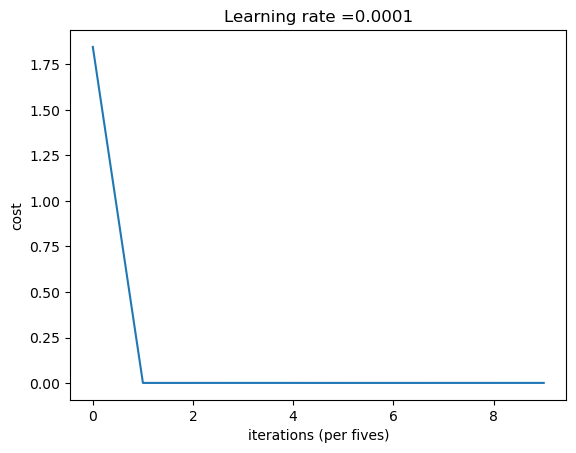

In [358]:
# Plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()

In [290]:
# splitting the dataset into test and train
# Define the train-test split ratio
train_ratio = 0.8  # 80% training, 20% testing

# Get the total size of the dataset
dataset_size = len(list(dataset))  # Convert dataset to a list to count elements
train_size = int(train_ratio * dataset_size)

# Shuffle the dataset (if required)
shuffled_dataset = dataset.shuffle(buffer_size=dataset_size, reshuffle_each_iteration=False)

# Split the dataset into training and testing subsets
train_dataset = shuffled_dataset.take(train_size)
test_dataset = shuffled_dataset.skip(train_size)

# Extract X_train, Y_train, X_test, Y_test for explicit use
X_train = train_dataset.map(lambda features, target: features)
Y_train = train_dataset.map(lambda features, target: target)
X_test = test_dataset.map(lambda features, target: features)
Y_test = test_dataset.map(lambda features, target: target)